# AMS 747 Project: Learning with kernels 
## Numerical experiment

In [28]:
import numpy as np

# target functions
def smooth(x):
    return np.sin(2*np.pi*2*x)

def nonsmooth(x):
    return np.where((x % 0.5) < 0.25, 1, -1)
    
x_range = np.arange(0, 1, 0.01).reshape(-1, 1)
target_s = smooth(x_range)
target_ns = nonsmooth(x_range)

In [29]:
# generate data
def generate_data(n, target):
    x = np.random.rand(n).reshape(-1, 1)
    y = target(x) + np.random.normal(loc=0, scale=0.25, size=n).reshape(-1, 1) # f(x) + error
    return x,y

In [30]:
# kernel bandwidth = median{|x_i - x_j|} (Bach, pg 193)
# x = input
# n = sample size
def bw(x, n):
    D = []
    for i in np.arange(n-1):
        for j in np.arange(i+1, n):
            D.append(np.abs(x[i] - x[j]))

    r = np.median(D)
    return(r)

# kernels
# make kernel with bandwidth r

# exponential kernel
# (Bach, pg 192)
def K_expo_factory(r):   
    def K_expo(x1, x2):
        dist = np.abs(x1[:, None] - x2[None, :])
        a = dist / r
        return np.exp(-a)
    return K_expo

# Matern kernel (s = (d + 5)/2 = 3)
# (Bach, pg 193)
def K_mtrn_factory(r):
    def K_mtrn(x1, x2):
        dist = np.abs(x1[:, None] - x2[None, :])
        a = np.sqrt(5)*dist/r
        return (1 + a + a**2/3)*np.exp(-a)
    return K_mtrn

# Gaussian kernel
# (Bach, pg 193)
def K_gaus_factory(r):
    def K_gaus(x1, x2):
        dist = np.abs(x1[:, None] - x2[None, :])
        a = dist / r
        return np.exp(-a**2)
    return K_gaus

In [31]:
# mean squared error
def mse(y, y_pred):
    return np.mean((y_pred - y)**2)

# excess risk
def excess_risk(x, model, target):
    y_star = target(x)
    y_pred = model.predict(x)
    return mse(y_star, y_pred)


In [32]:
from sklearn.kernel_ridge import KernelRidge

# train
sample_size = np.round(np.logspace(1, 3, 15)).astype(int)
N = np.shape(sample_size)[0]

# arrays to save excess risks
ER_expo_s = np.zeros(N)
ER_expo_ns = np.zeros(N)
ER_mtrn_s = np.zeros(N)
ER_mtrn_ns = np.zeros(N)
ER_gaus_s = np.zeros(N)
ER_gaus_ns = np.zeros(N)

In [33]:
from sklearn.base import clone

for i in np.arange(N):
    print(i)
    M = 20
    n = sample_size[i]
    for j in np.arange(M): # repeat each experiment M times
        # generate data
        x_s, y_s = generate_data(n, smooth)
        x_ns, y_ns = generate_data(n, nonsmooth)

        # compute kernel bandwidth
        r_s = bw(x_s, n)
        r_ns = bw(x_ns, n)
        
        # make kernes
        K_expo_s = K_expo_factory(r_s)
        K_expo_ns = K_expo_factory(r_ns)
        K_mtrn_s = K_mtrn_factory(r_s)
        K_mtrn_ns = K_mtrn_factory(r_ns)
        K_gaus_s = K_gaus_factory(r_s)
        K_gaus_ns = K_gaus_factory(r_ns)

        # fit exponential model
        model_expo_s = KernelRidge(alpha=1/n, kernel=K_expo_s) # λ = k(x,x)^2 / n (Bach pg 214)
        model_expo_ns = KernelRidge(alpha=1/n, kernel=K_expo_ns)
        model_expo_s.fit(x_s, y_s)
        model_expo_ns.fit(x_ns, y_ns)
        # save excess risk
        ER_expo_s[i] = ER_expo_s[i] + excess_risk(x_range, model_expo_s, smooth)
        ER_expo_ns[i] = ER_expo_ns[i] + excess_risk(x_range, model_expo_ns, nonsmooth)

        # fit matern model
        model_mtrn_s = KernelRidge(alpha=1/n, kernel=K_mtrn_s)
        model_mtrn_ns = KernelRidge(alpha=1/n, kernel=K_mtrn_ns)
        model_mtrn_s.fit(x_s, y_s)
        model_mtrn_ns.fit(x_ns, y_ns)
        # save excess risk
        ER_mtrn_s[i] = ER_mtrn_s[i] + excess_risk(x_range, model_mtrn_s, smooth)
        ER_mtrn_ns[i] = ER_mtrn_ns[i] + excess_risk(x_range, model_mtrn_ns, nonsmooth)

        # fit matern model
        model_gaus_s = KernelRidge(alpha=1/n, kernel=K_gaus_s)
        model_gaus_ns = KernelRidge(alpha=1/n, kernel=K_gaus_ns)
        model_gaus_s.fit(x_s, y_s)
        model_gaus_ns.fit(x_ns, y_ns)
        # save excess risk
        ER_gaus_s[i] = ER_gaus_s[i] + excess_risk(x_range, model_gaus_s, smooth)
        ER_gaus_ns[i] = ER_gaus_ns[i] + excess_risk(x_range, model_gaus_ns, nonsmooth)

    if n==100:
        example_x_s = x_s
        example_y_s = y_s
        example_x_ns = x_ns
        example_y_ns = y_ns
        example_model_expo_s = model_expo_s.predict(x_range)
        example_model_mtrn_s = model_mtrn_s.predict(x_range)
        example_model_gaus_s = model_gaus_s.predict(x_range)
        example_model_expo_ns = model_expo_ns.predict(x_range)
        example_model_mtrn_ns = model_mtrn_ns.predict(x_range)
        example_model_gaus_ns = model_gaus_ns.predict(x_range)

ER_expo_s = ER_expo_s/M
ER_expo_ns = ER_expo_ns/M
ER_mtrn_s = ER_mtrn_s/M
ER_mtrn_ns = ER_mtrn_ns/M
ER_gaus_s = ER_gaus_s/M
ER_gaus_ns = ER_gaus_ns/M

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


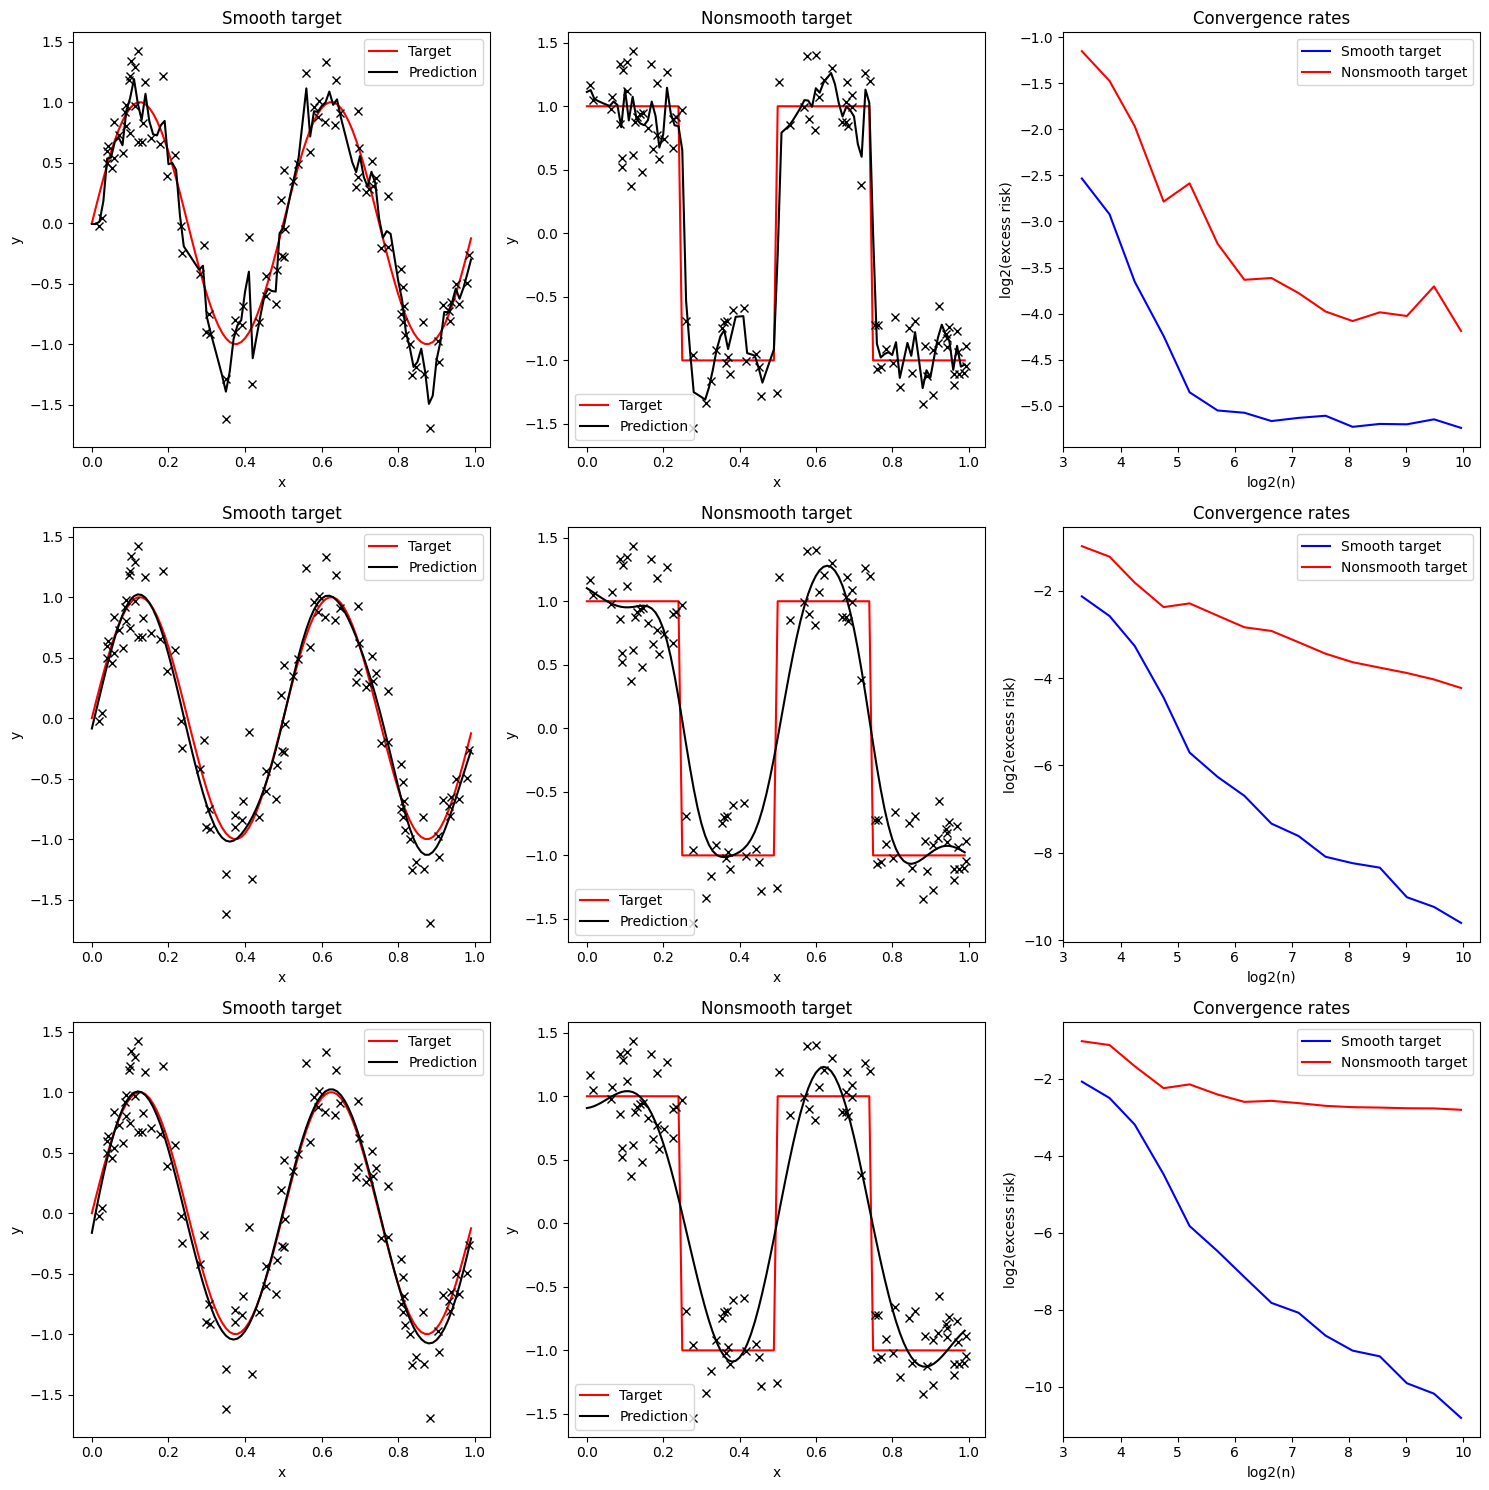

In [34]:
import matplotlib.pyplot as plt

# plot functions
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# smooth
axs[0,0].plot(x_range, target_s, 'r-', label='Target')
axs[0,0].plot(x_range, example_model_expo_s, 'k-', label='Prediction')
axs[0,0].plot(example_x_s, example_y_s, 'kx')
axs[0,0].set_title("Smooth target")
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].legend()

axs[1,0].plot(x_range, target_s, 'r-', label='Target')
axs[1,0].plot(x_range, example_model_mtrn_s, 'k-', label='Prediction')
axs[1,0].plot(example_x_s, example_y_s, 'kx')
axs[1,0].set_title("Smooth target")
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].legend()

axs[2,0].plot(x_range, target_s, 'r-', label='Target')
axs[2,0].plot(x_range, example_model_gaus_s, 'k-', label='Prediction')
axs[2,0].plot(example_x_s, example_y_s, 'kx')
axs[2,0].set_title("Smooth target")
axs[2,0].set_xlabel('x')
axs[2,0].set_ylabel('y')
axs[2,0].legend()

# nonsmooth
axs[0,1].plot(x_range, target_ns, 'r-', label='Target')
axs[0,1].plot(x_range, example_model_expo_ns, 'k-', label='Prediction')
axs[0,1].plot(example_x_ns, example_y_ns, 'kx')
axs[0,1].set_title("Nonsmooth target")
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0,1].legend()

axs[1,1].plot(x_range, target_ns, 'r-', label='Target')
axs[1,1].plot(x_range, example_model_mtrn_ns, 'k-', label='Prediction')
axs[1,1].plot(example_x_ns, example_y_ns, 'kx')
axs[1,1].set_title("Nonsmooth target")
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1,1].legend()

axs[2,1].plot(x_range, target_ns, 'r-', label='Target')
axs[2,1].plot(x_range, example_model_gaus_ns, 'k-', label='Prediction')
axs[2,1].plot(example_x_ns, example_y_ns, 'kx')
axs[2,1].set_title("Nonsmooth target")
axs[2,1].set_xlabel('x')
axs[2,1].set_ylabel('y')
axs[2,1].legend()

# convergence
axs[0,2].plot(np.log2(sample_size), np.log2(ER_expo_s), 'b-', label="Smooth target")
axs[0,2].plot(np.log2(sample_size), np.log2(ER_expo_ns), 'r-', label="Nonsmooth target")
axs[0,2].set_title("Convergence rates")
axs[0,2].set_xlabel('log2(n)')
axs[0,2].set_ylabel('log2(excess risk)')
axs[0,2].legend()

axs[1,2].plot(np.log2(sample_size), np.log2(ER_mtrn_s), 'b-', label="Smooth target")
axs[1,2].plot(np.log2(sample_size), np.log2(ER_mtrn_ns), 'r-', label="Nonsmooth target")
axs[1,2].set_title("Convergence rates")
axs[1,2].set_xlabel('log2(n)')
axs[1,2].set_ylabel('log2(excess risk)')
axs[1,2].legend()

axs[2,2].plot(np.log2(sample_size), np.log2(ER_gaus_s), 'b-', label="Smooth target")
axs[2,2].plot(np.log2(sample_size), np.log2(ER_gaus_ns), 'r-', label="Nonsmooth target")
axs[2,2].set_title("Convergence rates")
axs[2,2].set_xlabel('log2(n)')
axs[2,2].set_ylabel('log2(excess risk)')
axs[2,2].legend()

plt.tight_layout()
plt.show()